In [78]:
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [21]:

#Origem https://amazon-reviews-2023.github.io/main.html

df_meta = pd.read_json('./data/meta_Video_Games.jsonl.gz', lines=True)
df_review = pd.read_json('./data/Video_Games.jsonl.gz', lines=True)

In [17]:
# Não utilizado para este problema
filter = df_meta['title'].str.contains('playstation 5', case=False, na=False)

In [ ]:
''' Selecionado o item B0BN942894 - BENGOO Stereo Pro Gaming Headset for PS4, PC
    Estratégia produto como mais de 25000 reviews e nota inferior a 4.5
    Para que não tivessemos somente muitas notas altas'''
#df_meta[(df_meta['rating_number'] >= 25000) & (df_meta['parent_asin'] == 'B09C4DLF4P')].sort_values('rating_number', ascending=False)

#Mudança de estratégia para um produto que tivesse mais de 10000 reviews
df_meta[df_meta['parent_asin'] == 'B0BN942894'].sort_values('rating_number', ascending=False)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
7985,Computers,"BENGOO Stereo Pro Gaming Headset for PS4, PC, ...",4.3,2766,[【Multi-Platform Compatible】Support PlayStatio...,[],33.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Unboxing ', 'url': 'https://www.am...",BENGOO,"[Video Games, PC, Accessories, Headsets]","{'Brand': 'BENGOO', 'Series': 'G9000', 'Item m...",B0BN942894,NaN,NaN,NaN


In [86]:
df_headset = df_review[df_review['parent_asin'] == 'B0BN942894']

In [87]:
df_headset

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
839,5,Perfect,Great,[],B01H6GUCCQ,B0BN942894,AEPS4PAETQFKIPROSTLJDHQJAVKA,2020-02-08 17:00:38.466,0,True
1050,5,Good sound quality,Kids loved them,[],B01H6GUCCQ,B0BN942894,AGODEE2NRFP5H2KRXIZPZPV5QSJQ,2019-12-12 00:25:56.284,0,True
1103,5,Five Stars,ok,[],B01H6GUCCQ,B0BN942894,AE6PR5M6PXGJLE6X2MXADNEARJEA,2018-04-15 21:59:53.424,0,True
1117,1,Cheaply made poor quality,Item received broken poor quality. Adjusting h...,[],B01H6GUCCQ,B0BN942894,AGVKX5U6MGF7BOQEM33QCOF2OCPA,2019-12-13 12:22:03.049,0,True
1229,5,Good deal!,If you're really into gaming I should have thi...,[],B01H6GUCCQ,B0BN942894,AG4SYRMRQHJOPBIGDNWIG65RUXHQ,2020-02-06 00:13:38.967,0,True
...,...,...,...,...,...,...,...,...,...,...
4622982,5,These are awesome with my ps4,These are awesome with my ps4!! FYI: need a fe...,[],B01H6GUCCQ,B0BN942894,AHTN2M4GM5XTVGOZQ4CLFE4MBCXQ,2017-01-25 02:41:15.000,0,True
4623083,4,Great mic but...,I love this headset it has great sound quality...,[],B081JP3MJK,B0BN942894,AEH4ROCCLPHFDCPYKYXVCA6SJSTQ,2020-04-23 00:31:12.841,0,False
4623383,4,Four Stars,A little uncomfortable on the ears but still a...,[],B01H6GUCCQ,B0BN942894,AEIJQRBB3AM2PDE2XHVXKNDPM3RQ,2017-10-19 17:13:39.459,0,True
4624493,5,Nice headset,Great headset,[],B01H6GUCCQ,B0BN942894,AH7AHKGUD6Q4BC5XVYMX7YME3AHQ,2020-08-20 20:27:12.881,0,True


Análises de Frequências

In [88]:
# Distribuição por Nota
notes = df_headset.value_counts('rating')
notes = notes.reset_index()

fig = px.bar(
    notes.sort_values('rating'),
    x='rating',
    y='count',
    title='Frequência de Ratings do Razer Kraken X Ultralight Gaming Headset: 7.1',
    labels={'rating': 'Rating', 'count': 'Frequência'},
    text='count'
)

# Melhorar a aparência
fig.update_traces(marker_color='skyblue', textposition='outside')

# Exibir o gráfico
fig.show()


Nuvem de palavras

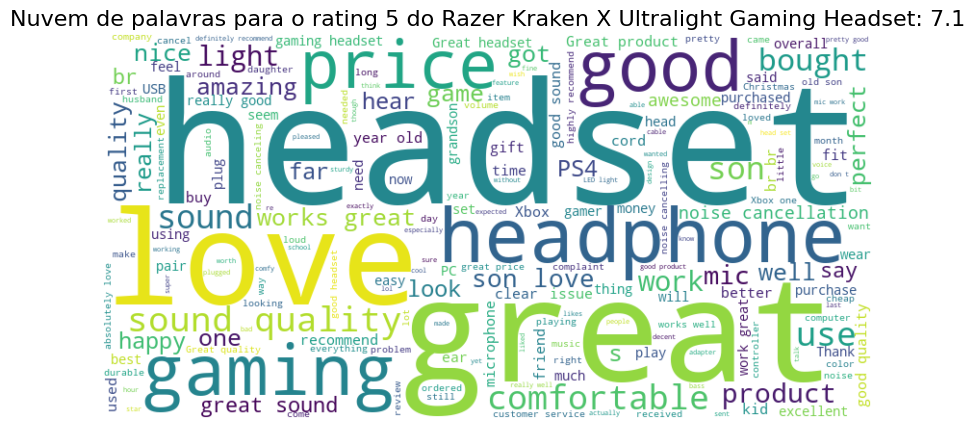

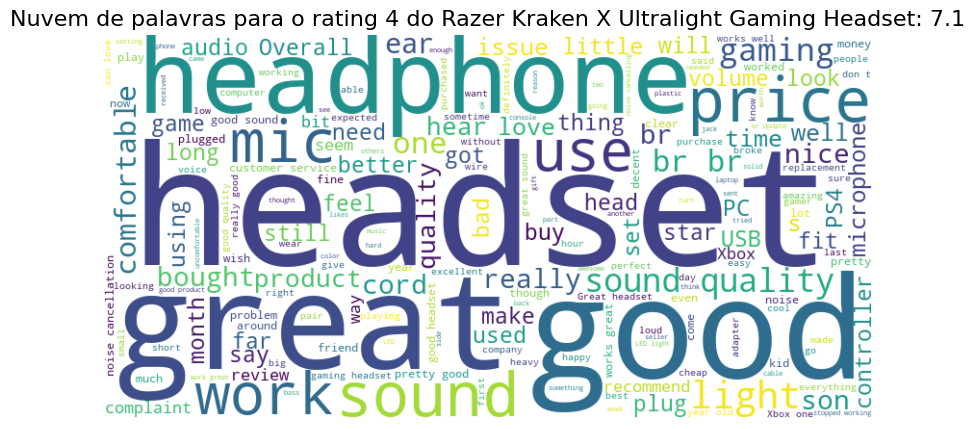

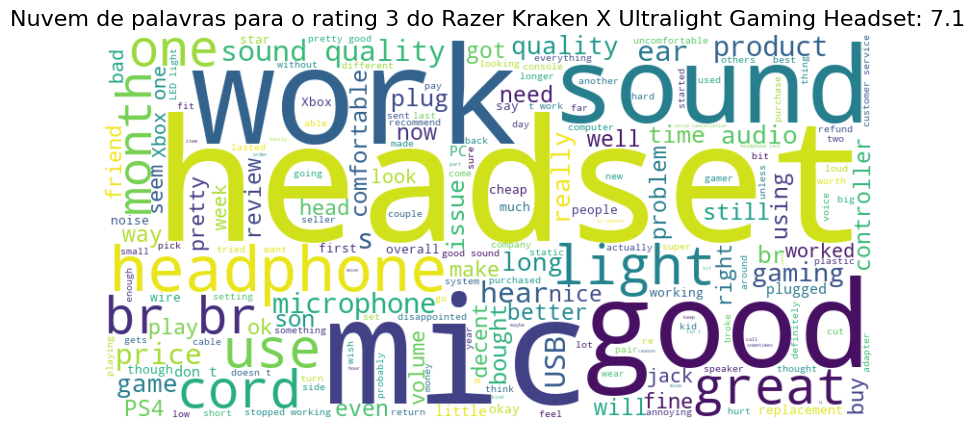

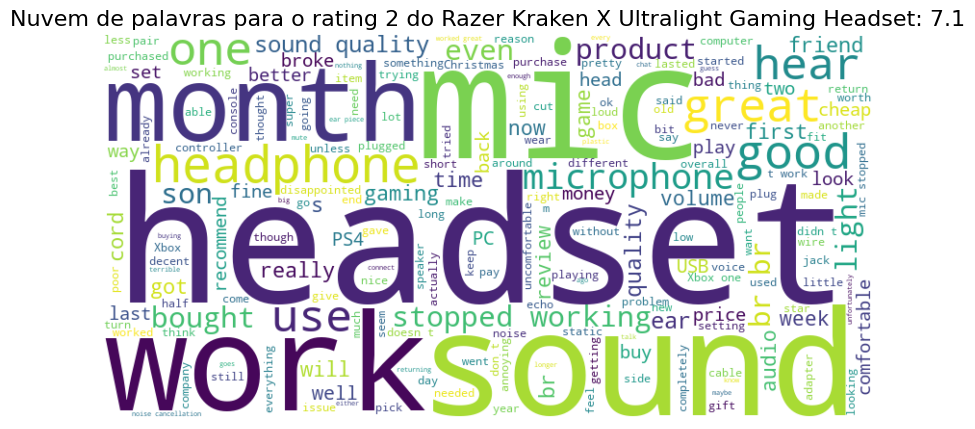

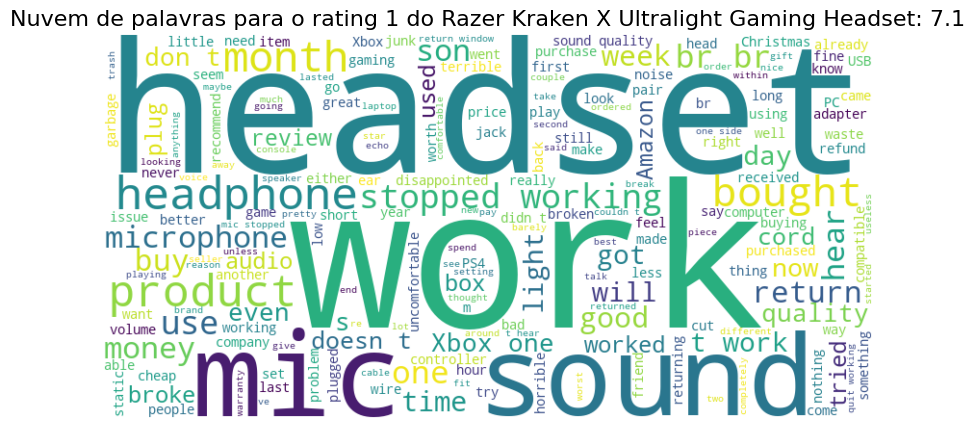

In [89]:
#Define os valores únicos de rating definindo do maior para o menor
unique_ratings = sorted(df_headset['rating'].unique(), reverse=True)

# Laço para plotar cada nuvem de palavras por único rating
for rating in unique_ratings:
    # Conccatenar todos os reviews (text) 
    text_data = " ".join(df_headset[df_headset['rating'] == rating]['text'].dropna())
    
    # Gerar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    
    # Plotar a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de palavras para o rating {rating} do Razer Kraken X Ultralight Gaming Headset: 7.1', fontsize=16)
    plt.show()


Preparação do Dataset

In [91]:
#Deixando somente as colunas de rating e text (reviews)
df_final = df_headset.drop(columns=['title', 'images', 'asin', 'parent_asin','user_id','timestamp','helpful_vote','verified_purchase'])

#Remoção dos valores nulos
df_final = df_final.dropna(subset=['text'])

df_final.shape

(17310, 2)

In [92]:
# Dividir os dados em treino e (validação + teste) (60/40)
train_data, temp_data = train_test_split(df_final, test_size=0.4, random_state=42, stratify=df_final['rating'])

# Passo 2: Dividir (validação + teste) em validação e teste
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['rating'])

# Exibir as dimensões dos conjuntos
print('Base de Treino', train_data.shape)
print('Base de Treino', val_data.shape)
print('Base Temporaria', test_data.shape)

Base de Treino (10386, 2)
Base de Treino (3462, 2)
Base Temporaria (3462, 2)


SVM + BOW

In [ ]:
# Vectorizar os textos usando BoW
vectorizer_bow = CountVectorizer(max_features=5000, stop_words='english')
X_train_bow = vectorizer_bow.fit_transform(train_data['text']).toarray()
X_test_bow = vectorizer_bow.transform(val_data['text']).toarray()

# Classes alvo
y_train = train_data['rating']
y_test = test_data['rating']

# Treinar o SVM com BoW
svm_bow = SVC(kernel='linear', random_state=42)
svm_bow.fit(X_train_bow, y_train)

# Predições
y_pred_train_bow = svm_bow.predict(X_train_bow)
y_pred_test_bow = svm_bow.predict(X_test_bow)

# Avaliação
accuracy_train_bow = accuracy_score(y_train, y_pred_train_bow)
accuracy_test_bow = accuracy_score(y_test, y_pred_test_bow)
f1_train_bow = f1_score(y_train, y_pred_train_bow, average='weighted')
f1_test_bow = f1_score(y_test, y_pred_test_bow, average='weighted')

accuracy_train_bow, accuracy_test_bow, f1_train_bow, f1_test_bow